In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris

df=pd.read_csv("C:/Users/thand/Downloads/Iris.csv")

In [2]:
df.head()

,sLen,sWid,pLen,pWid,Species
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


Trees Classification:

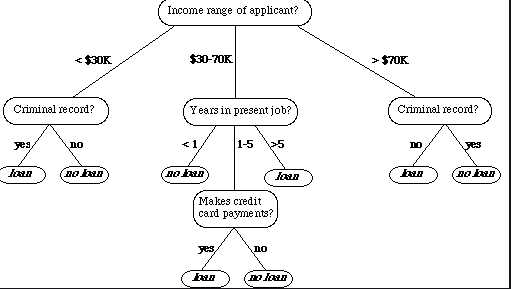

Necessity:
    1. No data prep is needed. No assumptions as such (Normality, heteroscedascity)
    2. No scaling is required. (Not based on distnace measure).
    3. Relatively insensitive to outliers
    4. Calssification is not a black-box. We can vizualize the tree based rules. (WIDELY USED IN INDUSTRIES)

How does the algorithm work:

The algorithm is a tree like model. At every stage, it looks for the best candidate to split the data on. The spliting criterian is based on the following two 


1. Information gain

step0: calculate the overall entropy -plog2(p)-plog2(p)
For everytime we need to split
step1: for every available column, for every levels, calculate entropy
step2: calculate the cols average entropy
step3: pick the column with the highest information gain (E(overall)-E(variable1)> than all others

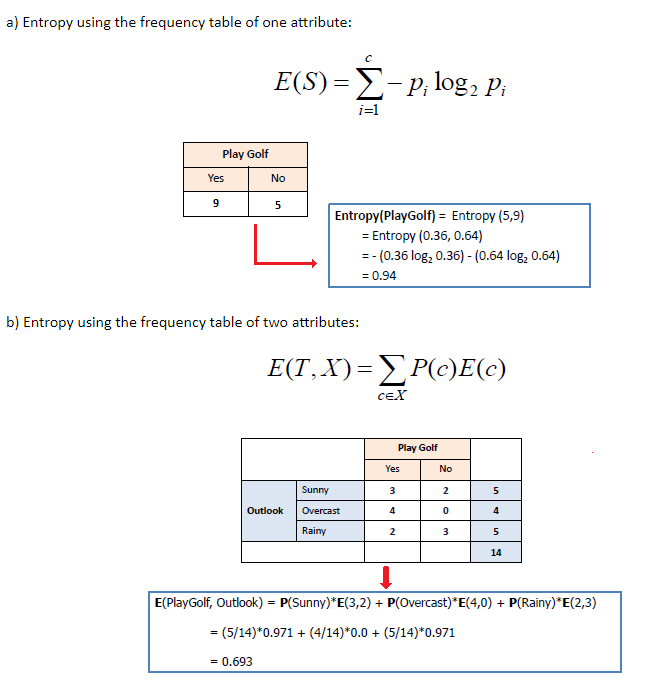

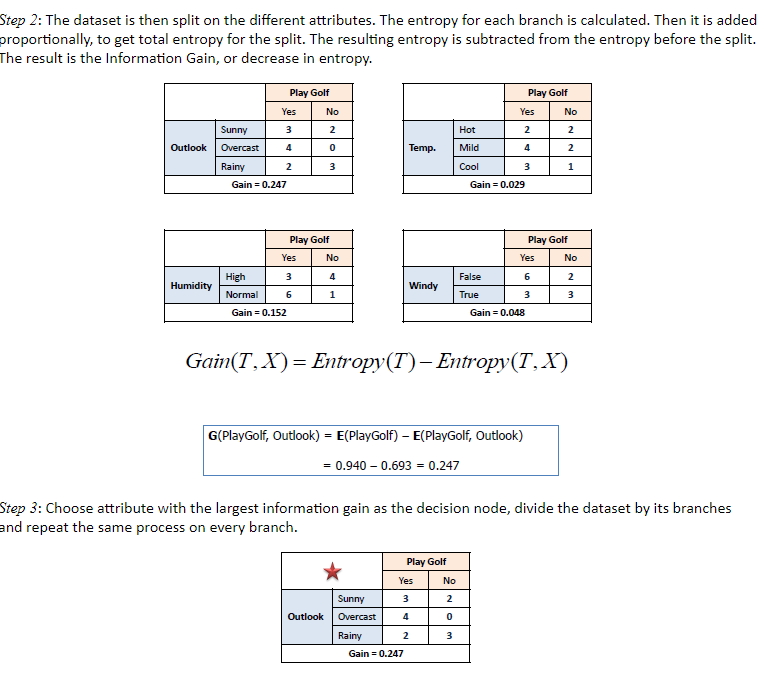


2. Gini Index

Same as Information gain, but with different formula.

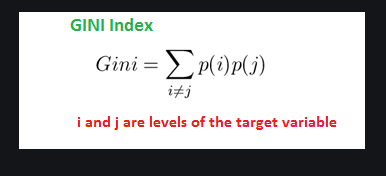

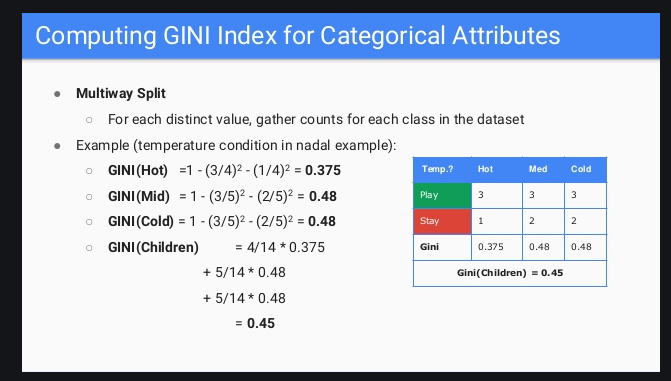

    

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [4]:
dtree=DecisionTreeClassifier()
x,y=df.drop('Species', axis=1), df.Species
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.5,random_state=1)
dtree.fit(x_train,y_train)
prediction=dtree.predict(x_test)

print("Decision tree accuracy:{}".format(metrics.accuracy_score(prediction,y_test)))
print("Confusion Metrix:\n",metrics.confusion_matrix(prediction,y_test))

Decision tree accuracy:1.0
Confusion Metrix:
 [[51  0]
 [ 0 24]]


In [14]:
from sklearn import tree
tree.export_graphviz(dtree,out_file="tree.dot")

Cons:
1. Overfitting
Trees are susuptible to overfitting. Generally High Variance and Low Bias
    To decrease the variance, we introduce the bias by pruning  the tree by defining the following
        1. Max depth
        2. Min samples at each node
        3. Max childNode
        4. Max feature to consider to split
2. Not suited for numerical values
Does not work well with numerical methods: (same as categorical split, the col is sorted in ascending order and for every value, information gain is assessed. (computational heavy. One way to deal with this is to bin numerical variables)
Example: range(100) can be binned into 10 categories (i.e.) 0-10, 10-20....90-100
3. suboptimal splits:
At each level, DT considers only suboptimal gain with out taking the overall gain in to notion. Example, at step 2, the best split may  be variable c but for overall variable d might be the best split.

Below code is for pruning the tree by introducing bias. I have used Grid search to get the best parameters


In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

dt= DecisionTreeClassifier(random_state=1234)
params = {
          'max_features': ['auto', 'sqrt', 'log2'],
          'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
          'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11],
          'random_state':[123]}

model1 = GridSearchCV(dt, param_grid=params, n_jobs=-1, cv=3)
model1.fit(x_train,y_train)

print("Best Hyper Parameters:",model1.best_params_)

print("Decision tree accuracy:{}".format(metrics.accuracy_score(prediction,y_test)))
print("Confusion Metrix:\n",metrics.confusion_matrix(prediction,y_test))



C:\Users\thand\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Hyper Parameters: {'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 123}
Decision tree accuracy:1.0
Confusion Metrix:
 [[51  0]
 [ 0 24]]


Random Forests

1. Why Random Forests?
    1. Trees overfit. Inorder to reduce the variance we introduce bias by pruning the tree.
 
2. How does Random Forests improvise?
    1. Instead of creating one tree with all variables and records, RF creates multiple tress. Each tree is based on bagging, an ensemble technique. Each tree is trained on a subset of variables and subset of records. An prediction is then based on the Max votes (classification) / Avg value (regression)

Pseudo Code:
	1. If there are N records, 'n' samples are taken at random with replacement
	2. If there are M variables, m<M vairables are selected at each node to grow a tree. .m is held constant
	3. After growing, unseen data is scored.
The most voted class amongst the trees is the final validation!

End to end: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
Implementation:https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76
Hyperparameter tuning: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74


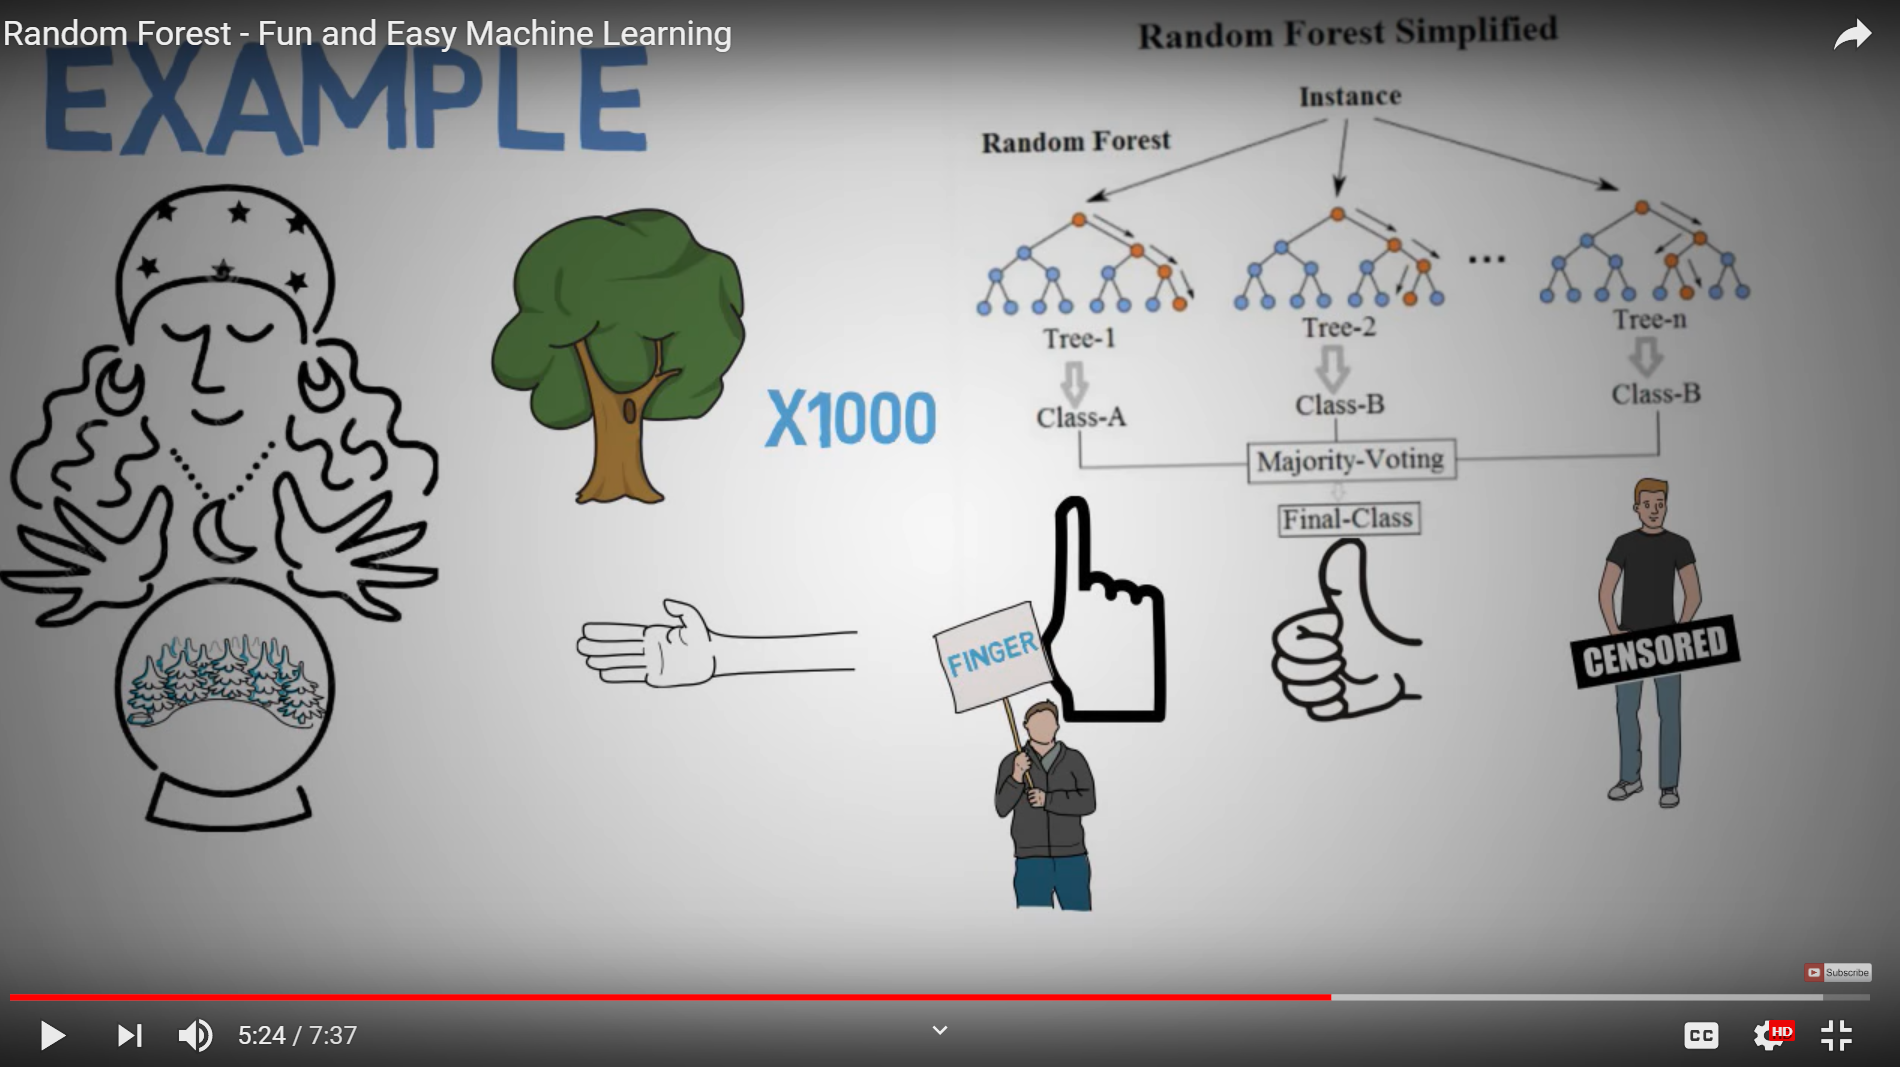

3. Disadvantages:
    1. Computaionaly heavy


In [27]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')

model.fit(x_train,y_train)
prediction=model.predict(x_test)

print("Accuracy:{}".format(metrics.accuracy_score(prediction,y_test)))
print("Accuracy:{}".format(metrics.confusion_matrix(prediction,y_test)))

#predicted probability
rf_probs = model.predict_proba(test)[:, 1]  #you can append this to a DF for targeting based on sorted P values

Accuracy:1.0
Accuracy:[[51  0]
 [ 0 24]]


In [31]:
#feature importance
fi = pd.DataFrame({'feature': list(x_train.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi  # we can use this for 

,feature,importance
2,pLen,0.507523
3,pWid,0.404502
0,sLen,0.081751
1,sWid,0.006225


In [35]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [34]:
# Hyper parameter tuning

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)


grid_search.fit(x_train,y_train)

print("Best parameters{}".format(grid_search.best_params_))

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 198 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 684 tasks      | elapsed:  1.1min


Best parameters{'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}


[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  1.4min finished


In [36]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, x_test, y_test)

Model Performance
Average Error: 0.0000 degrees.
Accuracy = 100.00%.


In [38]:
#feature importance
fi = pd.DataFrame({'feature': list(x_train.columns),
                   'importance': grid_search.best_estimator_.feature_importances_}).\   #take note of grid_search.best_estimator
                    sort_values('importance', ascending = False)
fi  # we can use this for 

,feature,importance
3,pWid,0.504505
2,pLen,0.359306
0,sLen,0.130377
1,sWid,0.005813


# support Vector Machines

Wiki: https://en.wikipedia.org/wiki/Support-vector_machine
YouTube: https://www.youtube.com/watch?v=Y6RRHw9uN9o

Important things to Note:
1. SVM is non probabilistic model

Basics: SVM tries to fit a linear line which best separates the two classes. (selects the line having the maximum distance between two classes. For non linear feature space, the Kernal functions takes in the vectors and converts them into Dot products in higher space where linear separation is possible!

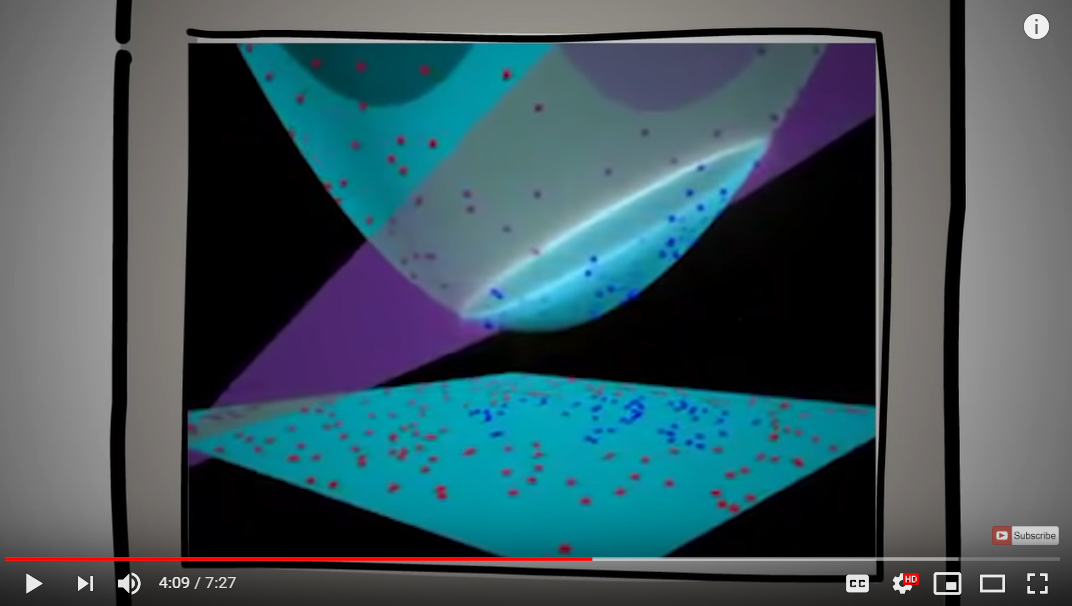

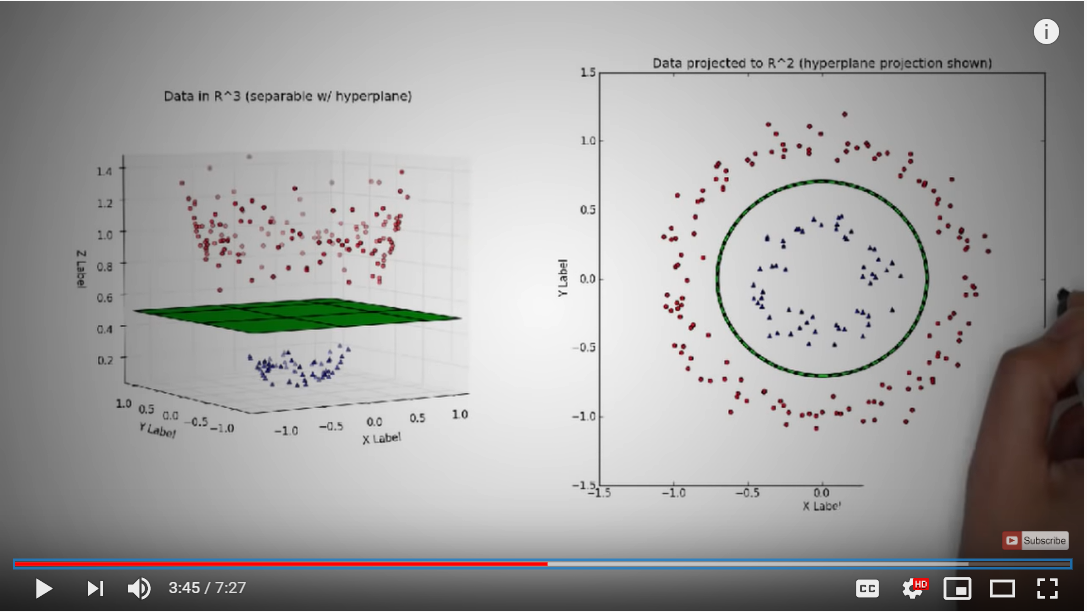


Improving Predictions:
1. Hyperparameter tunning (c,Kernal functions)
2. Use DT or Random forests to select important variables
3. Point 2 has proven to be not very useful in most cases. We can use feature weighing  ( did not find proper resource)
4. Normalize and scale the features as SVM is a distance based algorithm


Advantages:
1. Efficient in high dimensional space
2. Memory efficient
3. Performs well if there is a clear margin of seperation

Disadvantages:
1. Long training time if data is too large
2. Does not perform well if there are overlapsi in the data



In [49]:
from sklearn.svm import SVC
model = SVC(kernel='linear', C=1,gamma="auto")
model.fit(x_train,y_train)
prediction=model.predict(x_test)
print("Accuracy:{}".format(metrics.accuracy_score(prediction,y_test)))
print("Accuracy:{}".format(metrics.confusion_matrix(prediction,y_test)))



Accuracy:1.0
Accuracy:[[51  0]
 [ 0 24]]


In [45]:
#hyper parameter tuning

model = SVC()
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf','linear','poly']}  

grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(x_train,y_train)
print("Best parameters\n{}".format(grid_search.best_params_))
print(evaluate(best_grid, x_test, y_test))


grid_search.best_params_

Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters
{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Model Performance
Average Error: 0.0000 degrees.
Accuracy = 100.00%.
100.0


[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    0.2s finished
C:\Users\thand\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# KNN Classifier

A distance based classification algorithm. Scaling and Normalizing is important.
Lazy learner, memorizes the algorithm and does scoring

Pros of kNN:
1. Non-parametric, No assumption on data, not much data preparation (normalization etc)
2. Insensitive to outliers
3. Simple but relatively high accuracy
Cons kNN:
1. High memory requirement (as it needs all data to make prediction)
2. Computational expensive (same reason)
3. Could be slow if database is large (same reason)

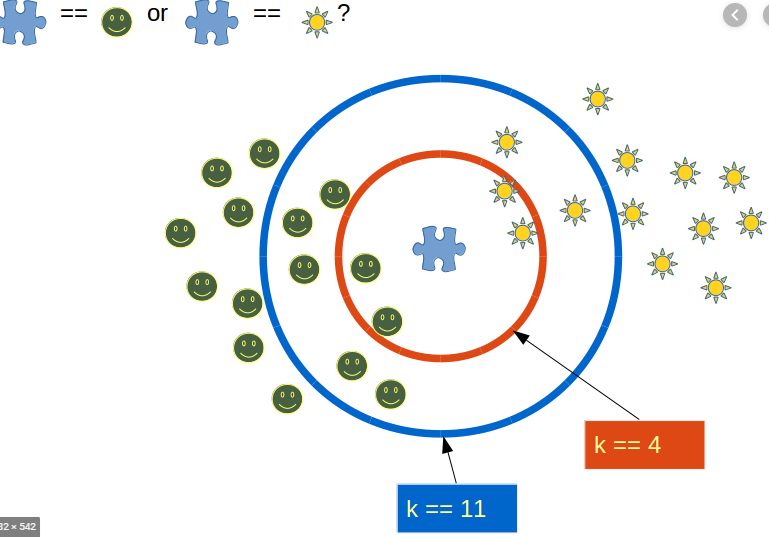	


Disadvantage:
1. When there is class imbalance, there is a classification bias towards the class with majority
Use weight='distance' to weigh the https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [51]:
from sklearn.neighbors import KNeighborsClassifier

#knn = KNeighborsClassifier(n_neighbors = 3)
knn = KNeighborsClassifier(n_neighbors = 3, weights='distance')
knn.fit(x_train,y_train)
prediction = knn.predict(x_test)

print("Accuracy:{}".format(metrics.accuracy_score(prediction,y_test)))
print("Accuracy:{}".format(metrics.confusion_matrix(prediction,y_test)))

Accuracy:1.0
Accuracy:[[51  0]
 [ 0 24]]


In [52]:
#parameter tuning:

model = KNeighborsClassifier()
param_grid = {'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  
              'weights': ['uniform','distance'], 
              'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}  

grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(x_train,y_train)
print("Best parameters\n{}".format(grid_search.best_params_))
print(evaluate(best_grid, x_test, y_test))

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s


Best parameters
{'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'}
Model Performance
Average Error: 0.0000 degrees.
Accuracy = 100.00%.
100.0


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    3.7s finished


# XG Boost

Read this first: https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d


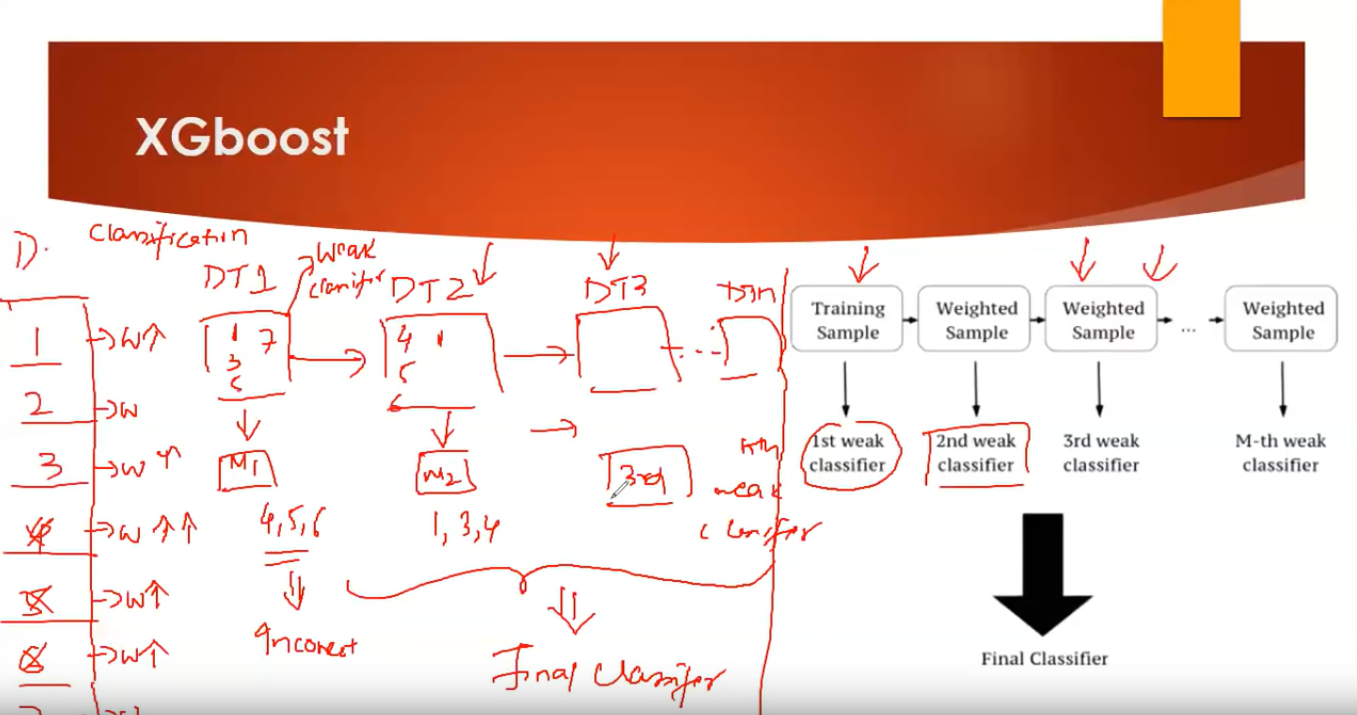


XG Boost Advantages:
1. Regularization:
    1. Standard GBM implementation has no regularization like XGBoost, therefore it also helps to reduce overfitting.
    2. In fact, XGBoost is also known as a ‘regularized boosting‘ technique.
    
2. Parallel Processing:
    1. XGBoost implements parallel processing and is blazingly faster as compared to GBM.

3. High Flexibility
    1. XGBoost allows users to define custom optimization objectives and evaluation criteria.
    2. This adds a whole new dimension to the model and there is no limit to what we can do.
4. Handling Missing Values
    1. XGBoost has an in-built routine to handle missing values.
    2. The user is required to supply a different value than other observations and pass that as a parameter. XGBoost tries different things as it encounters a missing value on each node and learns which path to take for missing values in future.
5. Tree Pruning:
    A GBM would stop splitting a node when it encounters a negative loss in the split. Thus it is more of a greedy algorithm.
    XGBoost on the other hand make splits upto the max_depth specified and then start pruning the tree backwards and remove splits beyond which there is no positive gain.
Another advantage is that sometimes a split of negative loss say -2 may be followed by a split of positive loss +10. GBM would stop as it encounters -2. But XGBoost will go deeper and it will see a combined effect of +8 of the split and keep both.
6. Built-in Cross-Validation
    XGBoost allows user to run a cross-validation at each iteration of the boosting process and thus it is easy to get the exact optimum number of boosting iterations in a single run.


Hyperparameter tuning: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

# XG Boost Vs RandomForest

# Boosting:
Boosting is based on weak learners (high bias, low variance). In terms of decision trees, weak learners are shallow trees, sometimes even as small as decision stumps (trees with two leaves). Boosting reduces error mainly by reducing bias (and also to some extent variance, by aggregating the output from many models).

https://medium.com/hackernoon/gradient-boosting-and-xgboost-90862daa6c77


# Random Forest
On the other hand, Random Forest uses as you said fully grown decision trees (low bias, high variance). It tackles the error reduction task in the opposite way: by reducing variance. The trees are made uncorrelated to maximize the decrease in variance, but the algorithm cannot reduce bias (which is slightly higher than the bias of an individual tree in the forest). Hence the need for large, unpruned trees, so that the bias is initially as low as possible.

Accuracy:1.0
Accuracy:[[51  0]
 [ 0 24]]


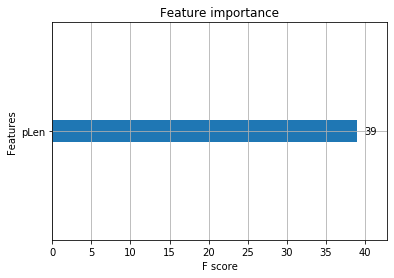

[0. 0. 1. 0.]


{'pLen': 321.4707399300001}

In [9]:
#Read this  https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7
#Gain:Improvement in accuracy brought by a feature to the branches it is on
#Coverage: Relative quantity of observations concerned by a feature


import xgboost as xgb
from xgboost import plot_importance
from xgboost.sklearn import XGBClassifier
from matplotlib import pyplot

model=XGBClassifier()
model.fit(x_train,y_train)
prediction=model.predict(x_test)
print("Accuracy:{}".format(metrics.accuracy_score(prediction,y_test)))
print("Accuracy:{}".format(metrics.confusion_matrix(prediction,y_test)))

#feature importance   (specifies cover)
plot_importance(model)
pyplot.show()
print(model.feature_importances_)

#feature importance   (gain)
model.get_booster().get_score(importance_type= 'total_cover')

In [60]:
   
param_grid = {'learning_rate': [0.1,0.20,0.3,0.4,0.5],  
              'n_estimators': [i for i in range(500,1500)], 
              'min_child_weight': [1,2,3,4],
              'gamma': [i/10.0 for i in range(0,5)],     #min loss required to make a split
              'max_depth':[4,5,6],                       #max depth of a tree
              'min_child_weight':[6,8,10,12],
              'subsample':[i/10.0 for i in range(6,10)], #Fraction of samples
              'colsample_bytree':[i/10.0 for i in range(6,10)], #fraction of cols
               'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],      #L1 reg weights
              'nthread': [1,2,3],             #no of cores needed
              'seed': [1,2],              #random seed
              #learning task parameter
              'objective':['binary:logistic']
             }  

grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(x_train,y_train)
print("Best parameters\n{}".format(grid_search.best_params_))
print(evaluate(best_grid, x_test, y_test))


grid_search.best_params_

MemoryError: 

# XG Boost Vs Ada Boost

# XG Boost
XG boost starts off with a weak classifier and builds a tree [COl and rows are subsetted with replacement]. 
For the next classfier, the rows that were misclassified previoiusly is given large weight. 
this step is repeated and the final strong classifier is generated
Voting is based on the popular/majority vote


# Ada Boost
Ada boost starts off with a weak stump. (one node, two leaves).
For the next classifier, a node which reduces the error from the previous classifier is prefereed. Note No sampling
Thus step is repeated and the final strong classifier is generated.
Voting is based on the cummulative individual classifiers weight ( each classifier is given a weight based on the error rate/ misclassification rate)

Feature Engineering

Feature Engineering:
Feature selection: XGBoost does the feature selection up to a level. In my experience, I always do feature selection by a round of xgboost with parameters different than what I use for the final model. I typically use low numbers for row and feature sampling, and trees that are not deep and only keep the features that enter to the model. Then fine tune with another model. This prevented overfitting for me when the number of features was very high.
Feature generation: XGBoost (classification, booster=gbtree) uses tree based methods. This means that the model would have hard time on picking relations such as ab, a/b and a+b for features a and b. I usually add the interaction between features by hand or select the right ones with some heuristics. Depending on the application, this can really boost the performance.

In [ ]:
#Log

logistic regression: very good explanation. No need further reference.
https://towardsdatascience.com/logistic-regression-python-7c451928efee

Assumptions: https://www.statisticssolutions.com/assumptions-of-logistic-regression/
1. Not like linear regression, none of following assumptions needs to be checked. (Normality, Linearity, Homoscedasticity)
2. Multicollinearity should be checked
3. Large enough sample size

Good to Know:
1. Scaling and normalizing is not required

Model Performance:
1. Add more variables
2. If none avaialable, good to try out other models
